### Imports

In [109]:
from os.path import abspath, join
import pandas as pd
import numpy as np
import re
from mizani.formatters import percent_format
from plotnine import ggplot, geom_bar, aes, scale_x_discrete, theme, element_text, labs, ylim,\
    scale_x_continuous, scale_y_continuous, geom_line, geom_boxplot,  xlim, facet_wrap, scale_fill_manual

### Global constants
Files and paths

In [110]:
base_dir = "C:/Nitsan/third/JavaAnalyzer"
analyzer_results_file = "analyzerResults_v2.csv"
external_words_file = "analyzerResults_words_ALL.csv"
german_words_file = "german.csv"
german_compound_words_list = "german_compound.csv"

Graphs parameters

In [111]:
fill='#5a9cd9'
log_x_scale_labels = ["1", "2-10", "11-100", "101-1000", "1001-10000", "10001-100000"]

Column headers

In [112]:
name_col = "name"
length_col = "length"
project_col = "project"
type_col = "className"
word_count_col = "wordCount"
count_col = "count"
freq_col = "frequency"
rank_col = "rank"

## Data load

In [113]:
df = pd.read_csv(abspath(join(base_dir, analyzer_results_file)))

## Data cleanup:
1. Remove type declarations:

In [114]:
df = df[~df[type_col].isin(["TypeParameter","ClassOrInterfaceType"])]

2. Remove external words:

In [115]:
external_tagging_data = pd.read_csv(abspath(join(base_dir, external_words_file)))
external_words = external_tagging_data[np.where(external_tagging_data['external'] == 1, True, False)]['word']
df= df[~df[name_col].isin(external_words)]

Removed words:

In [116]:
print(external_words)

0                          T
1                     String
3                          R
4                     Object
8                  Throwable
9             requireNonNull
19               IOException
20                   Integer
29                     Class
30                      List
37                       com
61                      java
84                         K
88          serialVersionUID
89                         V
115          AtomicReference
116                     Long
118                 toString
123                      Map
129                     Type
170     InterruptedException
194               Collection
202                 Iterable
211              InputStream
220                ArrayList
222                     Math
241                      Set
275                   Arrays
279             OutputStream
283                  Boolean
308               AtomicLong
327              Collections
336     NullPointerException
338            AtomicInteger
430         Ru

### Dataframe preview:

In [117]:
print(df.sample(frac=1))

              project                    name               className  \
387722  Signal-Server                  parent                NameExpr   
65606         Hystrix                  result                NameExpr   
377634  Signal-Server            verifyDevice                NameExpr   
420938        XXL-Job          exists_jobInfo                NameExpr   
143096        Jenkins                pendings         FieldAccessExpr   
...               ...                     ...                     ...   
88424         Jenkins              LineBuffer  ConstructorDeclaration   
380046  Signal-Server  platformFeedbackMeters                NameExpr   
196317        Jenkins          FormValidation                NameExpr   
259410        Jenkins           upstreamBuild                NameExpr   
210813        Jenkins                    proc               Parameter   

               role  length  
387722    REFERENCE       6  
65606     REFERENCE       6  
377634    REFERENCE      12  
420

## Histogram of 50 most common words in all projects together:

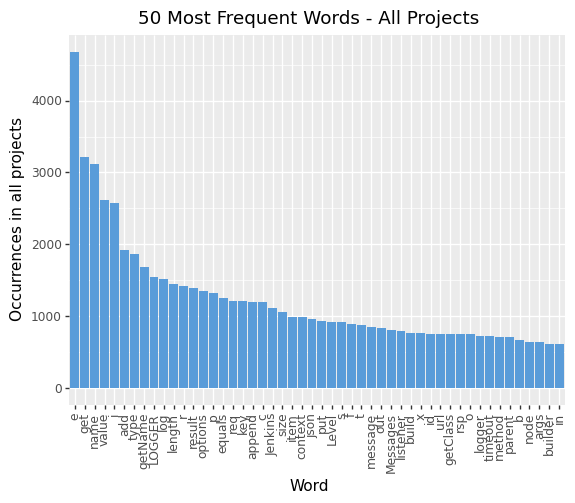

<ggplot: (195060565258)>


In [118]:
n = 50
word_occurrences_df = df.groupby([name_col, length_col])\
    .size()\
    .reset_index(name=count_col)\
    .sort_values(count_col, ascending=False)
word_occurrences_hist_df = word_occurrences_df.nlargest(n, count_col)

print(
	ggplot(word_occurrences_hist_df)
	+ labs(x="Word",
		   y="Occurrences in all projects",
		   title=str(n) + " Most Frequent Words - All Projects")
	+ scale_x_discrete(limits=word_occurrences_hist_df[name_col].tolist())
	+ geom_bar(aes(x=name_col, y=count_col), fill=fill, stat='identity')
	+ theme(axis_text_x=element_text(rotation=90))
)

### Zipf's Law - Words rank / frequency in log scale:

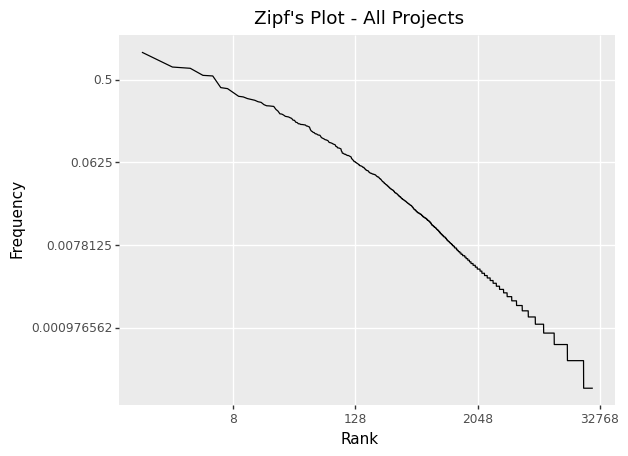

<ggplot: (195049766997)>


In [119]:
most_frequent_word_count = int(word_occurrences_df[:1][count_col])

# Add new normalized "frequency" column
word_occurrences_df[freq_col] = word_occurrences_df[count_col] / most_frequent_word_count
word_occurrences_df_length = word_occurrences_df.shape[0]
word_occurrences_df[rank_col] = np.linspace(1, word_occurrences_df_length, word_occurrences_df_length)

print(
    ggplot(word_occurrences_df)
    + labs(x="Rank",
           y="Frequency",
           title="Zipf's Plot - All Projects")
    + scale_x_continuous(trans='log2')
    + scale_y_continuous(trans='log2')
    + geom_line(aes(x=rank_col, y=freq_col), stat='identity')
)


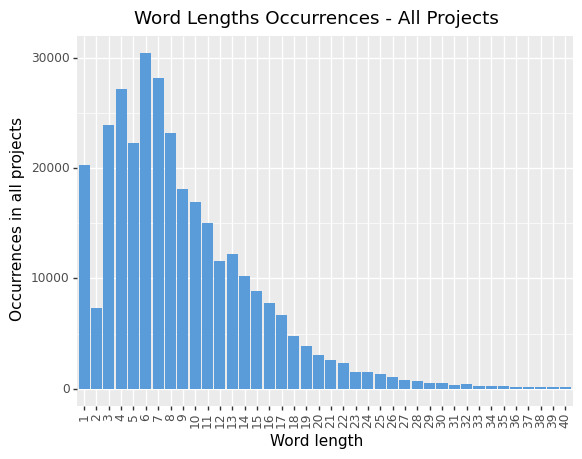

<ggplot: (195059003938)>


In [120]:
n = 40
length_occurrences_df = df.groupby([length_col]).size().reset_index(name=count_col)
length_occurrences_hist_df = length_occurrences_df.nsmallest(n, length_col)

print(
	ggplot(length_occurrences_hist_df)
	+ labs(x="Word length",
		   y="Occurrences in all projects",
		   title="Word Lengths Occurrences - All Projects")
	+ scale_x_discrete(limits=range(1, 41))
	+ geom_bar(aes(x=length_col, y=count_col), fill=fill, stat='identity')
	+ theme(axis_text_x=element_text(rotation=90))
)

### Add words rank per project

In [121]:
word_occurrences_per_project_df = df.groupby([name_col, length_col, project_col])\
    .size() \
    .reset_index(name=count_col) \
    .sort_values(count_col, ascending=False)

# Add rank column per project
# At the end of this process, we will have N rows in our dataframe with rank k,
# where N is the total number of project
projects = []
for project in word_occurrences_per_project_df[project_col].unique():
    project_df = word_occurrences_per_project_df[word_occurrences_per_project_df[project_col] == project]
    project_df.reset_index().sort_values(count_col, ascending=False)
    project_df_size = project_df.shape[0]
    project_df['project_rank'] = np.linspace(1, project_df_size, project_df_size)
    projects.append(project_df)

all_projects_df = pd.concat(projects)

# Calculate how many rank bins we'll need, cut the dataframe accordingly
bin_count = int(np.ceil(np.math.log(all_projects_df["project_rank"].max())))
all_projects_df["project_rank_bin"] = pd.cut(all_projects_df["project_rank"],
                                             bins=[0]+list(np.logspace(0, bin_count, bin_count+1)))

<ipython-input-121-747aced00e7e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  project_df['project_rank'] = np.linspace(1, project_df_size, project_df_size)


## Words' lengths by rank - per project breakdown

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_boxplot : Removed 1486 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


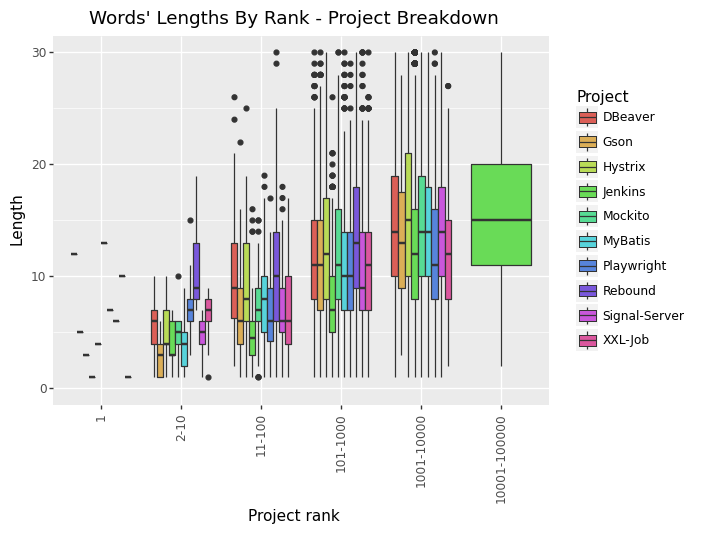

<ggplot: (195059071245)>


In [122]:
print(
    ggplot(all_projects_df)
    + labs(y="Length",
           x="Project rank",
           title="Words' Lengths By Rank - Project Breakdown",
           fill="Project")
    + geom_boxplot(aes(x='project_rank_bin', y=length_col, fill=project_col), position="dodge")
    + ylim(0, 30)
    + scale_x_discrete(limits=all_projects_df["project_rank_bin"].unique(), labels=log_x_scale_labels)
    + theme(axis_text_x=element_text(rotation=90))
      )

## Words' lengths by rank - all projects together

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_boxplot : Removed 1486 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


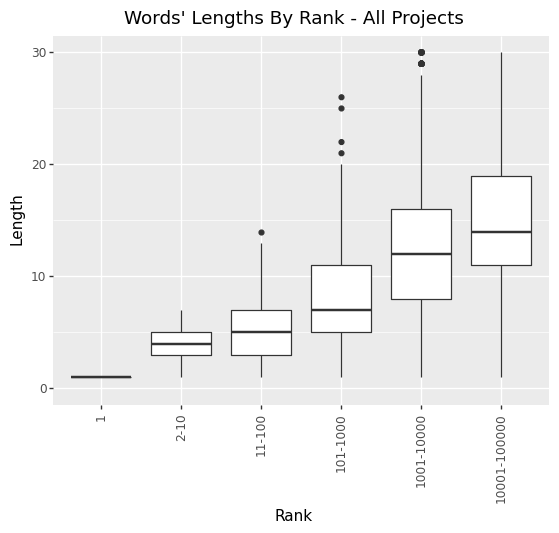

<ggplot: (195057414970)>


In [123]:
bin_count = int(np.ceil(np.math.log(word_occurrences_df.shape[0])))
word_occurrences_df["rank_bin"] = pd.cut(word_occurrences_df[rank_col], bins=[0]+list(np.logspace(0, bin_count, bin_count+1)))

print(ggplot(word_occurrences_df)
      + labs(y="Length",
             x="Rank",
             title="Words' Lengths By Rank - All Projects")
      + geom_boxplot(aes(x='rank_bin', y=length_col))
      + ylim(0, 30)
      + scale_x_discrete(labels=log_x_scale_labels)
      + theme(axis_text_x=element_text(rotation=90))
      )

## Compound Words - split and  count
### Define splitting function - by camelCase / PascalCase / snake_case:

In [124]:
def split_identifier_and_count(inpt):
	if inpt is None:
		return 0
	return len(re.findall(r'_?[A-Za-z_](?:[a-z0-9]+|[_A-Z]*(?=[_A-Z]|$))', str(inpt)))

# Make sure the count is correct for different cases:
assert split_identifier_and_count("UUIDa") == 2
assert split_identifier_and_count("_hello") == 1
assert split_identifier_and_count("well_hello") == 2
assert split_identifier_and_count("howDoYouDo") == 4
assert split_identifier_and_count("HowDoYouDo") == 4
assert split_identifier_and_count("okTTYLbye") == 3

### Split all names and add word count column:

In [125]:
word_occurrences_df[word_count_col] = word_occurrences_df[name_col]\
    .apply(split_identifier_and_count)\
    .astype('category')

word_occurrences_per_project_df = word_occurrences_per_project_df.merge(
    word_occurrences_df[[name_col, word_count_col]],
    on=name_col,
    how='left'
)

## Identifiers lengths frequency, with word count breakdown - per project:

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_count : Removed 889 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\positions\position.py:204: PlotnineWarning: position_stack requires non-overlapping x intervals
  warn(msg.format(cls.__name__), PlotnineWarning)
c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_bar : Removed 25 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


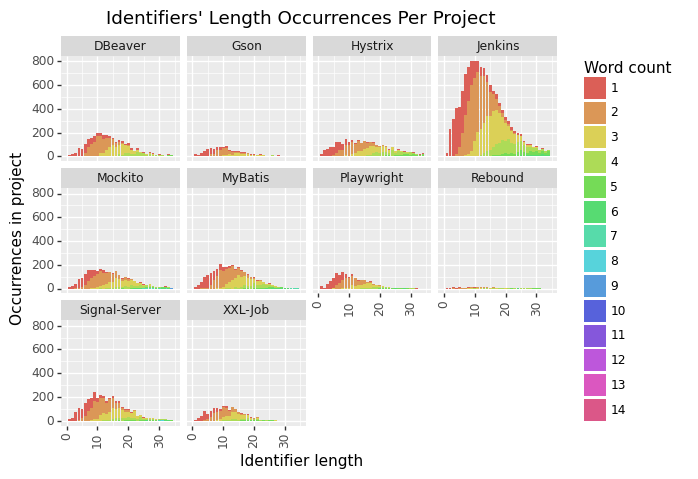

<ggplot: (195060731106)>


In [126]:
print(
	ggplot(word_occurrences_per_project_df)
	+ labs(x="Identifier length",
		   y="Occurrences in project",
		   title="Identifiers' Length Occurrences Per Project",
           fill="Word count")
	+ geom_bar(aes(x=length_col, fill=word_count_col))
  	+ xlim(0, 35)
	+ facet_wrap(project_col)
	+ theme(axis_text_x=element_text(rotation=90))
)

## Identifiers' lengths frequency with word count breakdown for all project combined:

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_count : Removed 889 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_bar : Removed 7 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


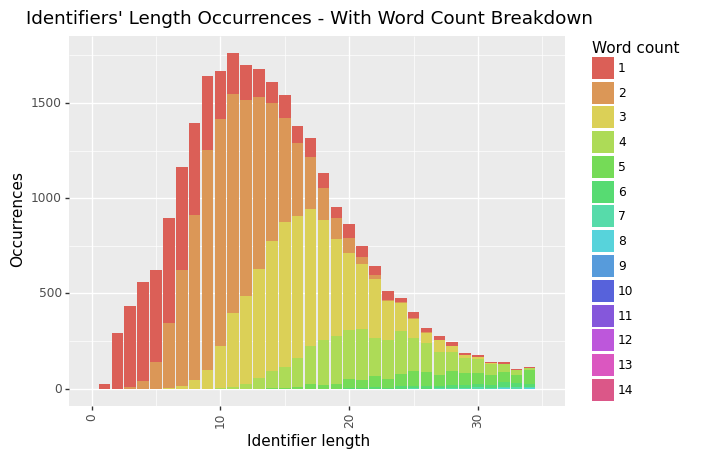

<ggplot: (195060732320)>


In [127]:
print(
	ggplot(word_occurrences_df)
	+ labs(x="Identifier length",
		   y="Occurrences",
		   title="Identifiers' Length Occurrences - With Word Count Breakdown",
           fill="Word count")
	+ geom_bar(aes(x=length_col, fill=word_count_col))
  	+ xlim(0, 35)
	+ theme(axis_text_x=element_text(rotation=90))
)

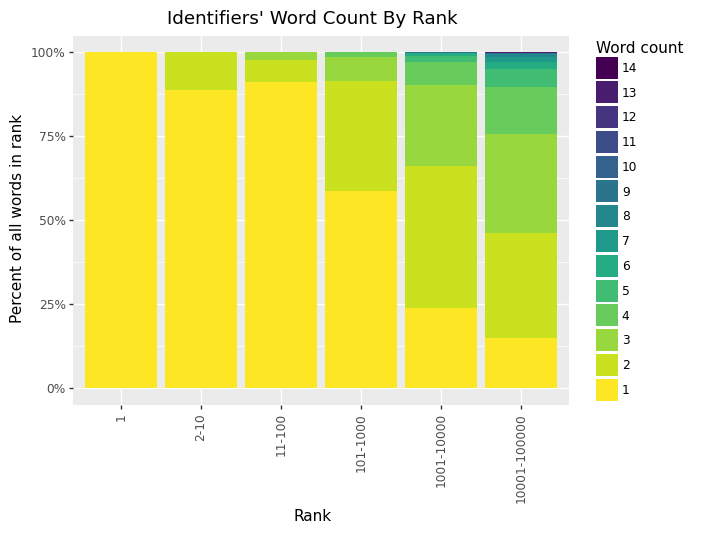

<ggplot: (195056593981)>


In [128]:
word_occurrences_df[word_count_col] = pd.Categorical(word_occurrences_df[word_count_col],
                                             categories=list(range(14, 0, -1)),
                                             ordered=True)

most_frequent_word_occurrences = int(word_occurrences_df[:1][count_col])
data_length = word_occurrences_df.shape[0]
word_occurrences_df[freq_col] = word_occurrences_df[count_col] / most_frequent_word_occurrences
word_occurrences_df[rank_col] = np.linspace(1, data_length, data_length)

bin_count = int(np.ceil(np.math.log(word_occurrences_df.shape[0])))
word_occurrences_df["rank_bin"] = pd.cut(word_occurrences_df[rank_col],
									bins=[0] + list(np.logspace(0, bin_count, bin_count + 1)))

print(
    ggplot(word_occurrences_df)
    + labs(x="Rank",
		   y="Percent of all words in rank",
		   title="Identifiers' Word Count By Rank",
           fill="Word count")
    + geom_bar(aes(x='rank_bin', fill=word_count_col), position="fill")
    + scale_y_continuous(labels=percent_format())
    + scale_x_discrete(labels=log_x_scale_labels)
    + theme(axis_text_x=element_text(rotation=90))
)

# Comparison to English / German corpora
## Setup Coca corpus data:

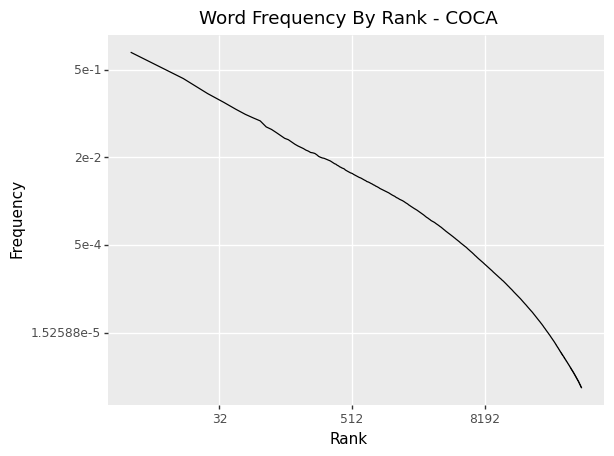

<ggplot: (195058856563)>
<ggplot: (195059293546)>


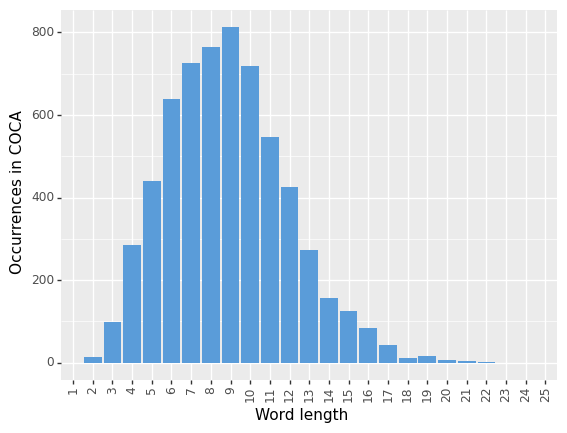

In [129]:
coca_data_file = "coca_sample.csv"
coca_df = pd.read_csv(abspath(join(base_dir, coca_data_file)))
coca_df[length_col] = coca_df['word'].str.len()

coca_word_freq = coca_df.groupby(["word", "rank"])[count_col].sum()\
	.reset_index()\
	.sort_values(count_col, ascending=False)
coca_most_freq_word_occurrences = int(coca_word_freq[:1][count_col])

coca_word_freq[count_col] = coca_word_freq[count_col] / coca_most_freq_word_occurrences

print(ggplot(coca_word_freq)
      + labs(x="Rank",
             y="Frequency",
             title="Word Frequency By Rank - COCA")
	  + scale_x_continuous(trans='log2') + scale_y_continuous(trans='log2')
	  + geom_line(aes(x=rank_col, y=count_col), stat='identity')
	  )

n = 25
coca_length_occurrences_df = coca_df.groupby([length_col]).size().reset_index(name=count_col)
coca_length_occurrences_df = coca_length_occurrences_df.nsmallest(n, length_col)

print(
	ggplot(coca_length_occurrences_df)
	+ labs(x="Word length",
		   y="Occurrences in COCA")
	+ scale_x_discrete(limits=range(1, 26))
	+ geom_bar(aes(x=length_col, y=count_col), fill=fill, stat='identity')
	+ theme(axis_text_x=element_text(rotation=90))
)


## Load German corpus data

In [130]:
german_df = pd.read_csv(abspath(join(base_dir, german_words_file)))
german_df = german_df.groupby([name_col]).frequency.sum().reset_index().sort_values(freq_col, ascending=False)
compound_words_df = pd.read_csv(abspath(join(base_dir, german_compound_words_list)))
compound_words_df["compound_word"] = compound_words_df["compound_word"].str.lower()
compound_words_set = set(compound_words_df["compound_word"])

### Define splitting function - recursively remove word head and apply function on tail:

In [131]:
def count_compound_word_parts(compound_word, count=0):
    word = str(compound_word).lower()
    if word is not None and word in compound_words_set:
        return count_compound_word_parts(
            compound_words_df[compound_words_df["compound_word"] == word].remainder.array[0],
            count + 1
        )
    else:
        return count + 1


german_df[word_count_col] = german_df[name_col].apply(count_compound_word_parts).astype('category')

### German data sample:

In [132]:
print(german_df.sample(frac=1))

                 name     frequency wordCount
56116      Strombörse   4072.000000         2
73354       entgegnet  16715.868950         1
48128     Reichsstadt  13544.000000         2
30220         Ioannis   6842.146771         1
78914  innenpolitisch   9935.000000         1
...               ...           ...       ...
57793   Theaterleiter   4785.000000         2
39456         Metall-  23460.000000         1
15683    Devisenmarkt   7639.000000         2
21362          Fluges  11252.000000         1
69490  beeindruckende  38402.000000         1

[93406 rows x 3 columns]


c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


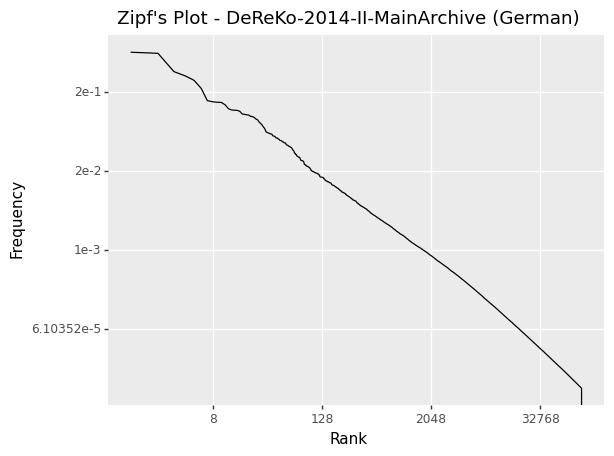

<ggplot: (195060732365)>
<ggplot: (195057814420)>
<ggplot: (195056589710)>


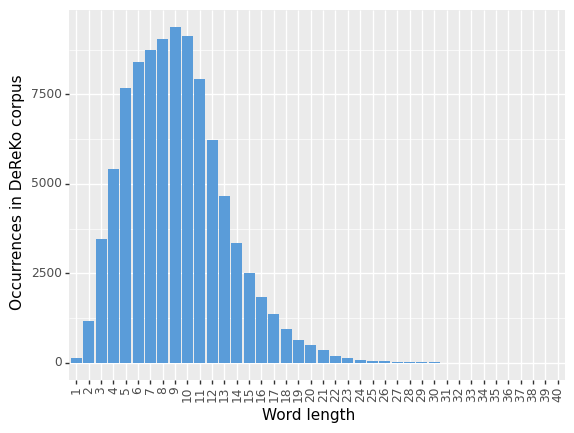

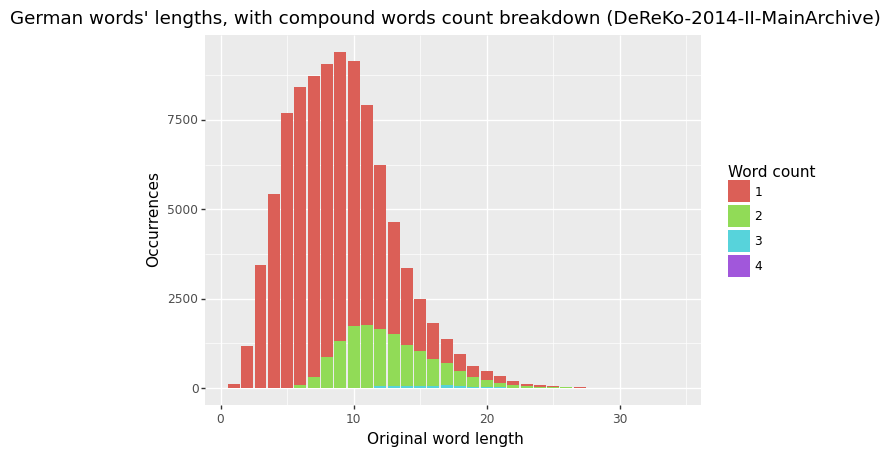

In [133]:
german_most_freq_word_occurrences = int(german_df[:1][freq_col])

german_df[freq_col] = german_df[freq_col] / german_most_freq_word_occurrences
german_df_length = german_df.shape[0]
german_df[rank_col] = np.linspace(1, german_df_length, german_df_length)

print(
    ggplot(german_df)
    + labs(x="Rank",
         y="Frequency",
         title="Zipf's Plot - DeReKo-2014-II-MainArchive (German)")
    + scale_x_continuous(trans='log2')
    + scale_y_continuous(trans='log2')
    + geom_line(aes(x=rank_col, y=freq_col), stat='identity')
)


german_df[length_col] = german_df[name_col].str.len()
n = 40
german_length_occurrences_df = german_df.groupby([length_col]).size().reset_index(name=count_col)
german_length_occurrences_df = german_length_occurrences_df.nsmallest(n, length_col)

print(
	ggplot(german_length_occurrences_df)
	+ labs(x="Word length",
		   y="Occurrences in DeReKo corpus")
	+ scale_x_discrete(limits=range(1, 41))
	+ geom_bar(aes(x=length_col, y=count_col), fill=fill, stat='identity')
	+ theme(axis_text_x=element_text(rotation=90))
)


print(
	ggplot(german_df)
	+ labs(x="Original word length",
		   y="Occurrences",
		   title="German words' lengths, with compound words count breakdown (DeReKo-2014-II-MainArchive)",
           fill="Word count")
	+ geom_bar(aes(x=length_col, fill=word_count_col))
)

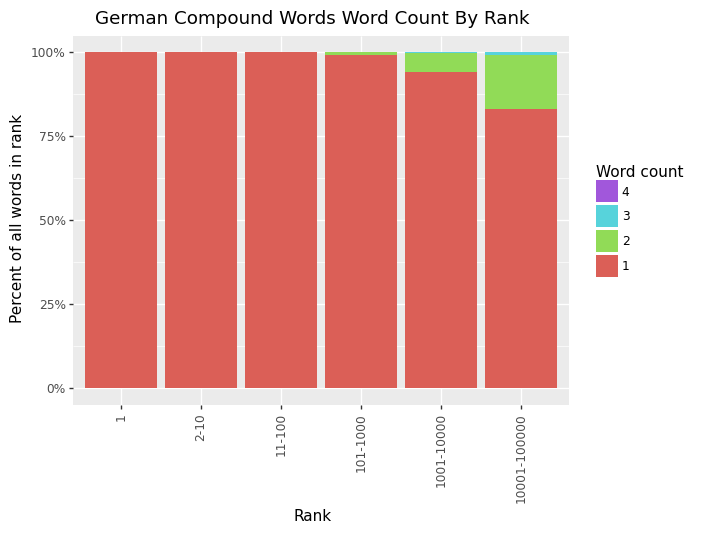

<ggplot: (195062289640)>


In [134]:

bin_count = int(np.ceil(np.math.log(german_df.shape[0])))
german_df["rank_bin"] = pd.cut(german_df[rank_col], bins=[0] + list(np.logspace(0, bin_count, bin_count + 1)))
german_df[word_count_col] = pd.Categorical(german_df[word_count_col],
                                             categories=list(range(4, 0, -1)),
                                             ordered=True)
print(
    ggplot(german_df)
    + labs(x="Rank",
		   y="Percent of all words in rank",
		   title="German Compound Words Word Count By Rank",
           fill="Word count")
    + geom_bar(aes(x='rank_bin', fill=word_count_col), position="fill")
    + scale_y_continuous(labels=percent_format())
    + scale_x_discrete(labels=log_x_scale_labels)
    + scale_fill_manual(["#a157db", "#57d3db","#91db57", "#db5f57"]) # unfortunate hack
    + theme(axis_text_x=element_text(rotation=90))
)